<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-surrogate-model-dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees as Surrogate Model for NNs

* Deep Neural Networks generalize well from training data
* However, they typically are black boxes and how they come to a conclusion is not comprehensible
* Some applications need explainabilty, though
  * the right to explanation is well established by the GDPR and United States' Credit score (https://en.wikipedia.org/wiki/Right_to_explanation, https://en.wikipedia.org/wiki/Credit_score_in_the_United_States)
  * neither Apple nor Goldman Sachs could explain why wife got worse score than husband in recent outbreak on twitter (https://twitter.com/dhh/status/1193391198922321921, https://twitter.com/chrisalbon/status/1193224719157190656, https://twitter.com/CNBC/status/1193992782630838278) 
* On top of that, NNs require more compute power and are hard to bring into production
* On the opoosite side, hand-written rules when crafted well are much more comprehensible, integrate easily into existing software and are inexpensive to execute
* Unfortunately, they are hard to come up with and either
  * generalize well but underfit by quite a bit
  * or are hard highly detailed and again overfit and are hard to maintain
* Decision Trees are of similar nature as those hand written rules, but can be trained from data and can either be geared towards understanability of accuracy
* Unlike Neural Networks they tend to overfit when trained on real world data
* But what if we train decision trees on data generated by a neural network tuned for generalization?
* As it turns out, this approch gives us a dial to be tuned between predictive power and explainability that goes all the way from hand crafted rules to deep neural networks


In [1]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

import numpy as np

# https://matplotlib.org/users/colormaps.html
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py
cmap = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

font_size=15
title_font_size=25

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 100
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   legend=False, # colab has old version of matplotlib, does not support
                   ax=None
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    if legend:
      class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
      ax.add_artist(class_legend)
    
    return ax, scatter


In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')

In [0]:
y = df['group'].values
X = df.drop('group', axis='columns').values

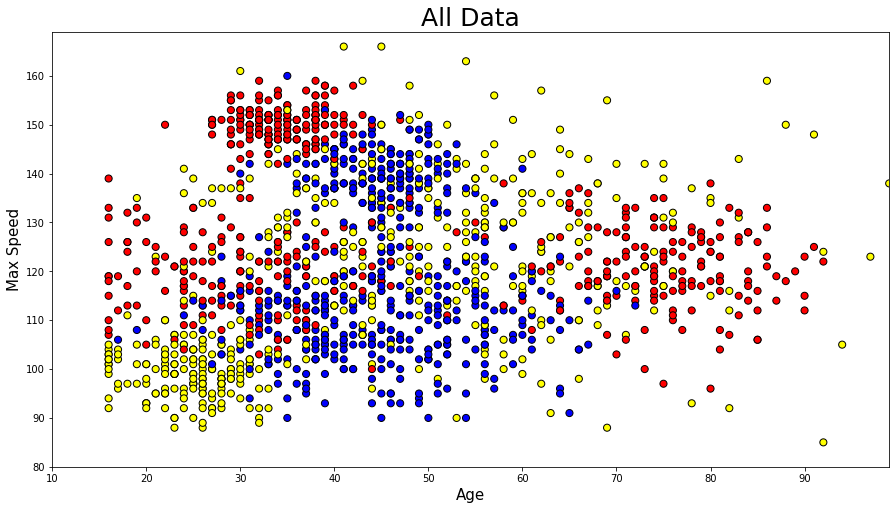

In [7]:
plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data");

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]
X_2_dim = X[:, :2]

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers

num_features = 2
num_categories = 3

dropout = 0.6
model = tf.keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

model.add(Dense(name='hidden1', 
                # units=2500, # for l1/l2
                # units=1500, # for l1 only
                units=500, # for dropout
                # kernel_regularizer=regularizers.l1(0.01)
                # kernel_regularizer=regularizers.l2(0.01)
                # kernel_regularizer=regularizers.l1_l2(0.005)
                ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='hidden2', 
              #  units=2500,
              #  units=1500,
               units=250,
              #  kernel_regularizer=regularizers.l1(0.01)
                # kernel_regularizer=regularizers.l2(0.01)
                # kernel_regularizer=regularizers.l1_l2(0.005)
              ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# does not bring anything
# model.add(Dense(name='hidden3', 
#                 units=1500,
#                 kernel_regularizer=regularizers.l1(0.01)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 250)               125250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250)               1

In [12]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
EPOCHS = 1000 # for bn / dropout
# EPOCHS = 3000 # for l1/l2

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    # validation_split=0.2, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 34.8 s, sys: 3.22 s, total: 38 s
Wall time: 30.2 s


In [13]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.6673532260788811, 0.72444445)

In [14]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.6735956768194834, 0.7183333)

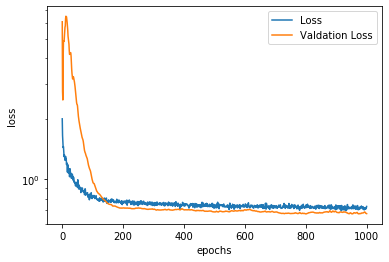

In [15]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"])

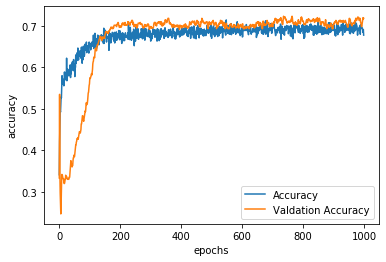

In [16]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6671324668>,
 <matplotlib.collections.PathCollection at 0x7f6671283710>)

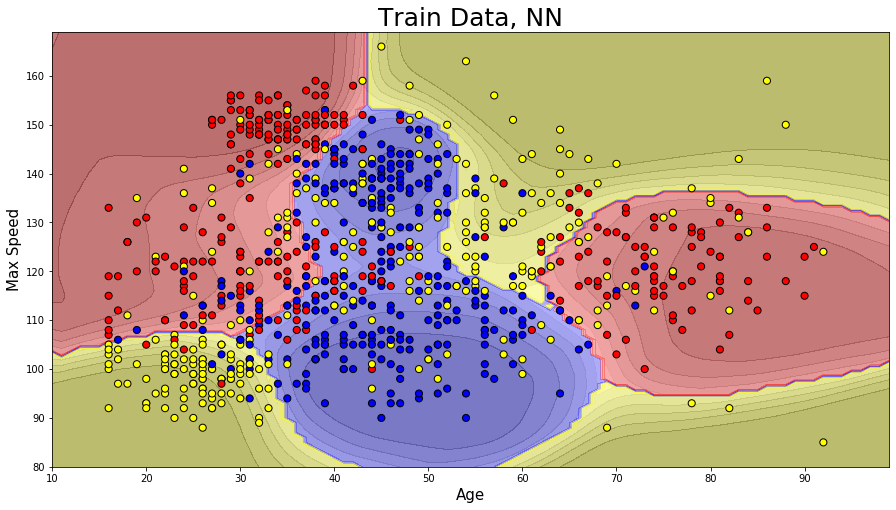

In [17]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN")

(<matplotlib.axes._subplots.AxesSubplot at 0x7f66706e8e10>,
 <matplotlib.collections.PathCollection at 0x7f66d2152048>)

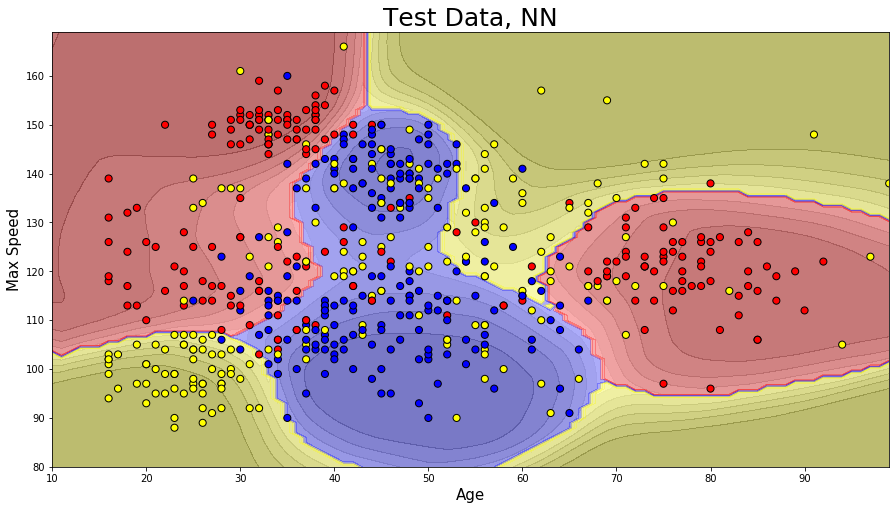

In [18]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN")

## Outstanding solution, but we can not explain it any more

## On the other side of the spectrum we have manual models, not powerful, but comprehensible

In [0]:
red = high = 0
green = low =1
yellow = medium = 2

probas = np.array([
                   [1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]
])

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def predict_proba(self, X):
        return np.array([probas[xi] for xi in self.predict(X)])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [0]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
random_clf = RandomClassifier()        

In [21]:
random_clf.score(X_2_dim, y)

0.3473333333333333

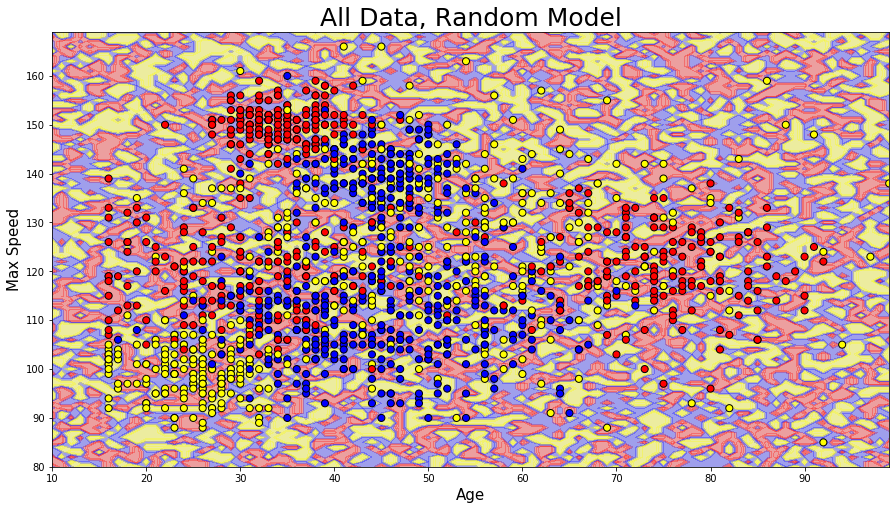

In [22]:
plotPrediction(random_clf, X_2_dim[:, 1], X_2_dim[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data, Random Model");

In [0]:
class RuleClassifier(ClassifierBase):
    def predict_single(self, x):
        speed, age = x
        if age < 25:
            if speed > 110:
                return high
            else:
                return medium
        if age > 70:
            return high
        if speed > 145:
            return high
        # this default vastly simplifies rule set    
        return low
rule_clf = RuleClassifier()        

In [114]:
rule_clf.score(X_2_dim, y)

0.5673333333333334

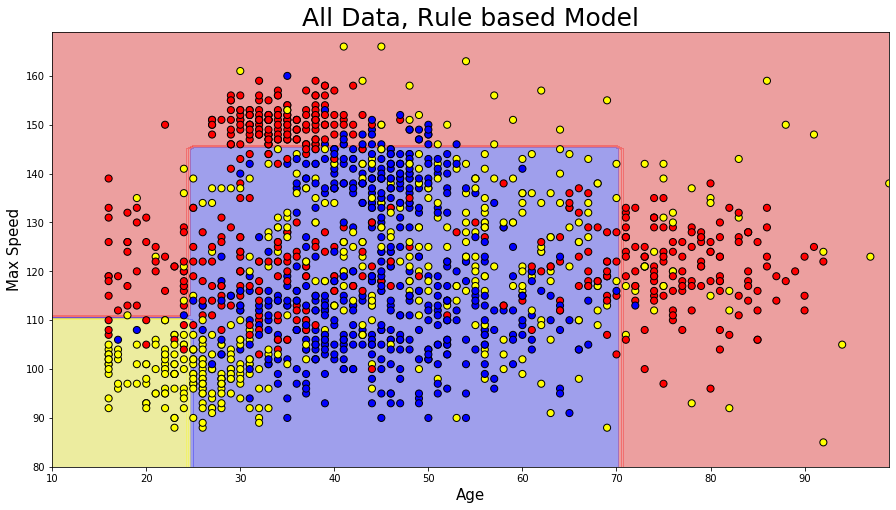

In [115]:
plotPrediction(rule_clf, X_2_dim[:, 1], X_2_dim[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data, Rule based Model");

# Main Question: Can we have the best of both worlds?
## Or at least more randomly choose how to compromise?

### Direct Training Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
%time dt_model.fit(X_train_2_dim, y_train)

CPU times: user 2.61 ms, sys: 0 ns, total: 2.61 ms
Wall time: 2.64 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [27]:
dt_model.score(X_train_2_dim, y_train)

0.96

In [28]:
dt_model.score(X_test_2_dim, y_test)

0.5916666666666667

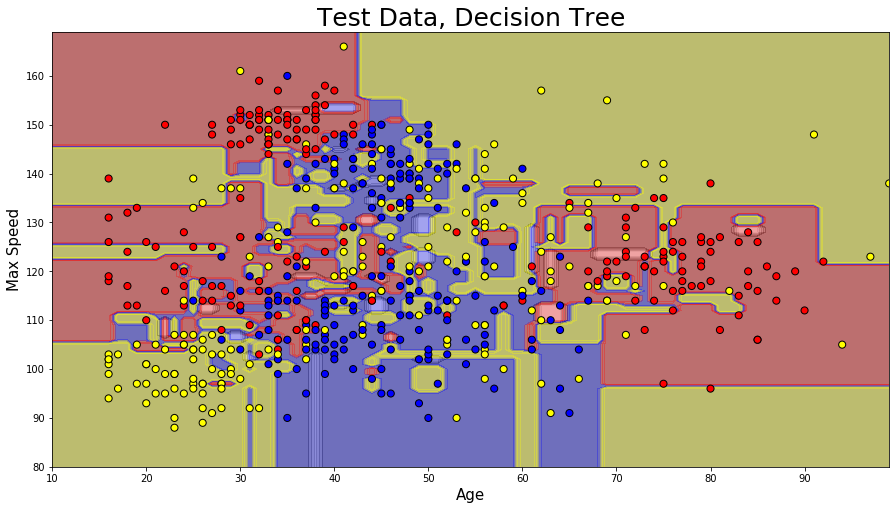

In [29]:
plotPrediction(dt_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree");

In [30]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=5)
%time dt_model.fit(X_train_2_dim, y_train)

CPU times: user 886 µs, sys: 1.01 ms, total: 1.9 ms
Wall time: 1.93 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [31]:
dt_model.score(X_train_2_dim, y_train)

0.7322222222222222

In [32]:
dt_model.score(X_test_2_dim, y_test)

0.675

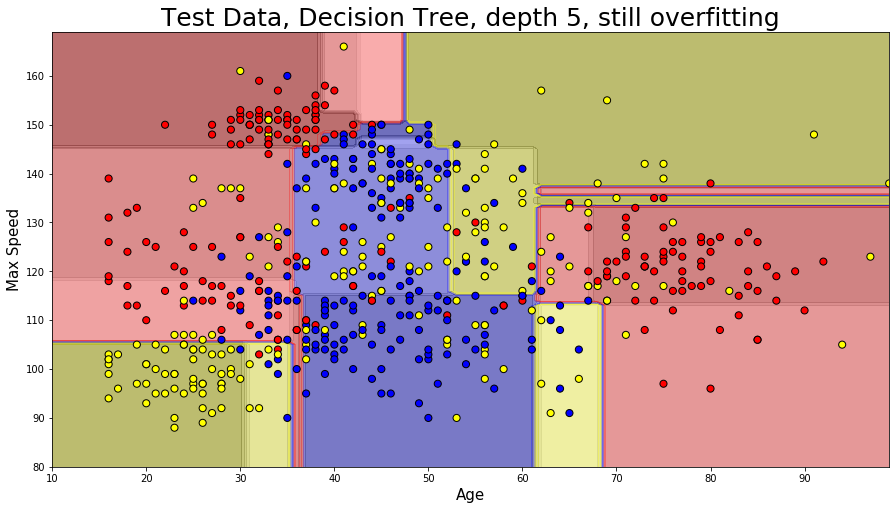

In [33]:
plotPrediction(dt_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree, depth 5, still overfitting");

### Surrogate Data

In [34]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 90), (90, 90))

In [35]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(8100, 2)

In [36]:
mesh_data[0]

array([80, 10])

In [37]:
pred = model.predict(mesh_data)
pred.shape

(8100, 3)

In [38]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(8100,)

In [39]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([3138, 1687, 3275]))

### Surrogate Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.15 ms, sys: 1.14 ms, total: 8.29 ms
Wall time: 12.1 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

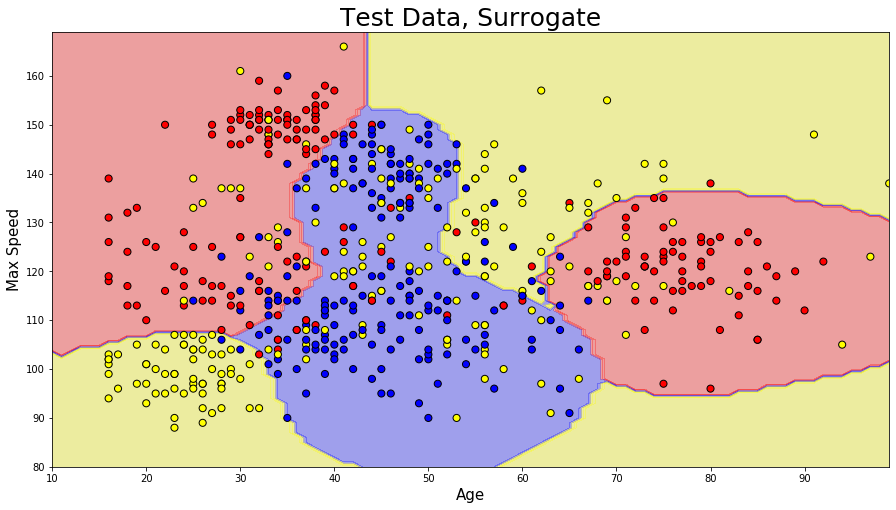

In [41]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [42]:
surrogate_model.tree_.max_depth

14

In [43]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [44]:
surrogate_model.score(X_train_2_dim, y_train)

0.7244444444444444

In [45]:
surrogate_model.score(X_test_2_dim, y_test)

0.7183333333333334

## Reduce Depth: 7

In [46]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=7)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 9.68 ms, sys: 44 µs, total: 9.73 ms
Wall time: 9.52 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [47]:
surrogate_model.tree_.max_depth

7

In [48]:
surrogate_model.score(mesh_data, pred_sparse)

0.9712345679012345

In [49]:
surrogate_model.score(X_train_2_dim, y_train)

0.7244444444444444

In [50]:
surrogate_model.score(X_test_2_dim, y_test)

0.7116666666666667

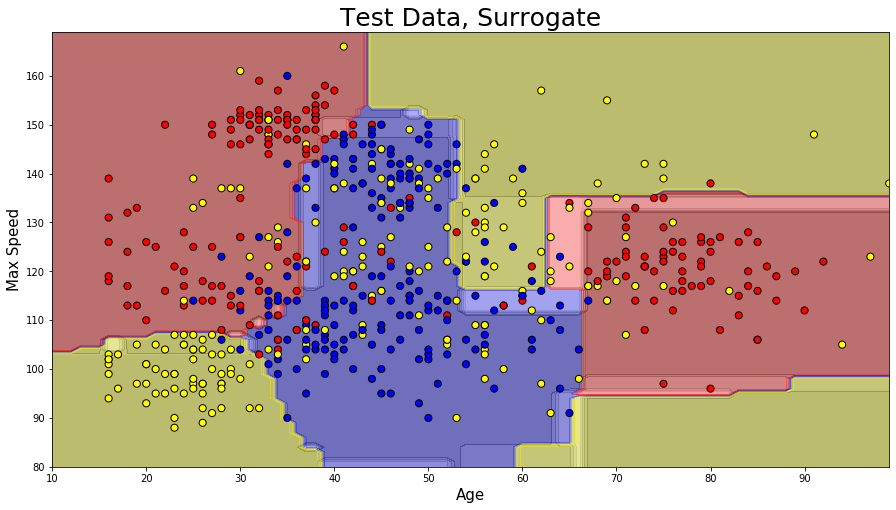

In [51]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 5

In [52]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 7.33 ms, sys: 1.04 ms, total: 8.37 ms
Wall time: 9.09 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [53]:
surrogate_model.tree_.max_depth

5

In [54]:
surrogate_model.score(mesh_data, pred_sparse)

0.9298765432098766

In [55]:
surrogate_model.score(X_train_2_dim, y_train)

0.6855555555555556

In [56]:
surrogate_model.score(X_test_2_dim, y_test)

0.6933333333333334

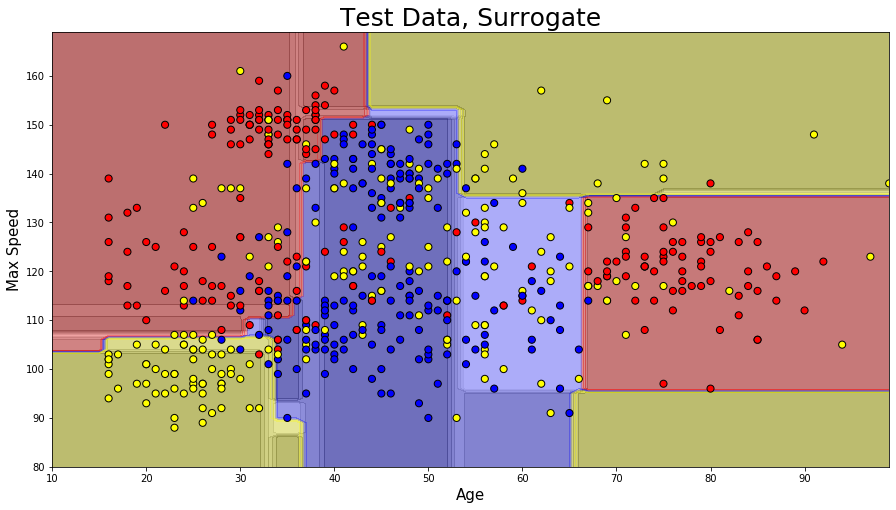

In [57]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 4

In [58]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=4)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.97 ms, sys: 0 ns, total: 6.97 ms
Wall time: 6.52 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [59]:
surrogate_model.tree_.max_depth

4

In [60]:
surrogate_model.score(mesh_data, pred_sparse)

0.8875308641975309

In [61]:
surrogate_model.score(X_train_2_dim, y_train)

0.6488888888888888

In [62]:
surrogate_model.score(X_test_2_dim, y_test)

0.6466666666666666

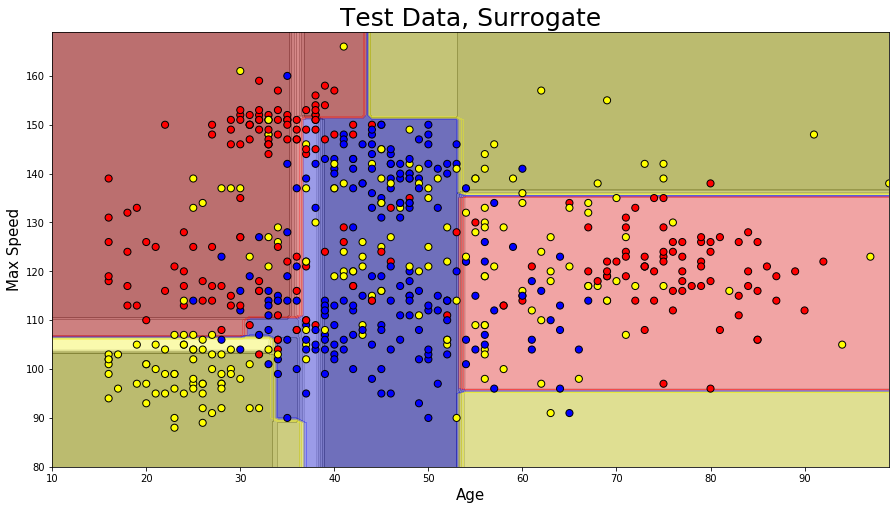

In [63]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 3

In [64]:
from sklearn.tree import DecisionTreeClassifier

# surrogate_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=250)
surrogate_model = DecisionTreeClassifier(max_depth=3)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.13 ms, sys: 0 ns, total: 6.13 ms
Wall time: 6.34 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [65]:
surrogate_model.tree_.max_depth

3

In [66]:
surrogate_model.score(mesh_data, pred_sparse)

0.7987654320987654

In [67]:
surrogate_model.score(X_train_2_dim, y_train)

0.6355555555555555

In [68]:
surrogate_model.score(X_test_2_dim, y_test)

0.6283333333333333

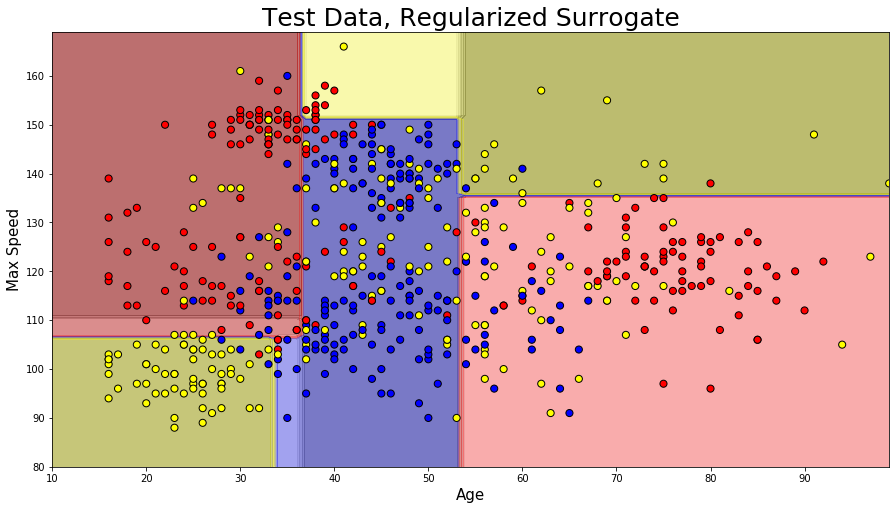

In [69]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

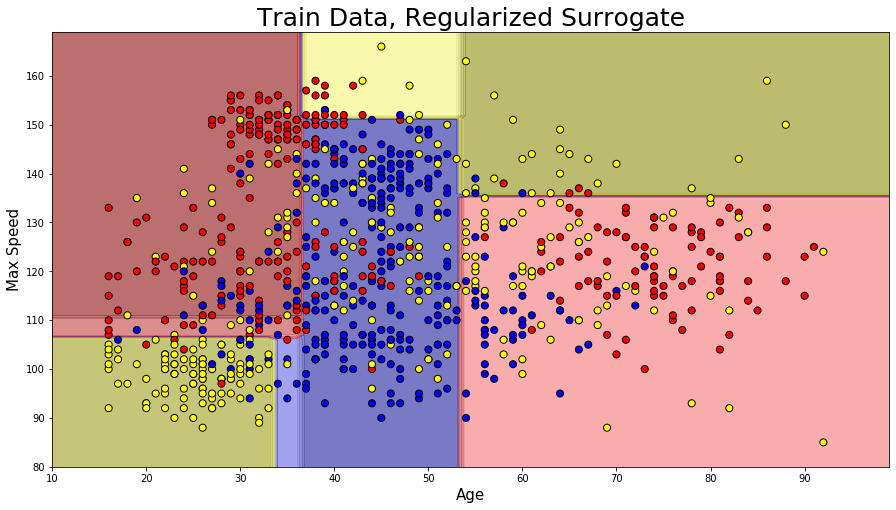

In [70]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 2

In [71]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=2)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.27 ms, sys: 23 µs, total: 5.29 ms
Wall time: 5.33 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [72]:
surrogate_model.tree_.max_depth

2

In [73]:
surrogate_model.score(mesh_data, pred_sparse)

0.7232098765432099

In [74]:
surrogate_model.score(X_train_2_dim, y_train)

0.6077777777777778

In [75]:
surrogate_model.score(X_test_2_dim, y_test)

0.575

In [76]:
surrogate_model.score(X_2_dim, y)

0.5946666666666667

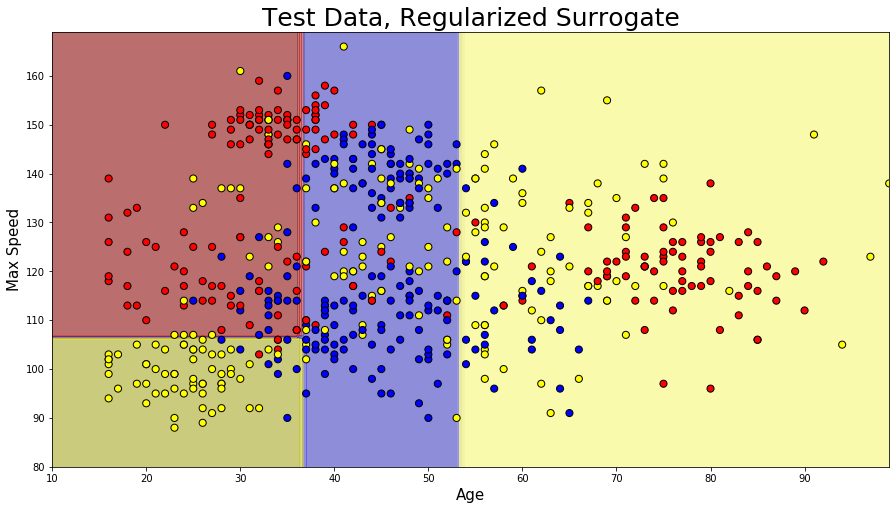

In [77]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

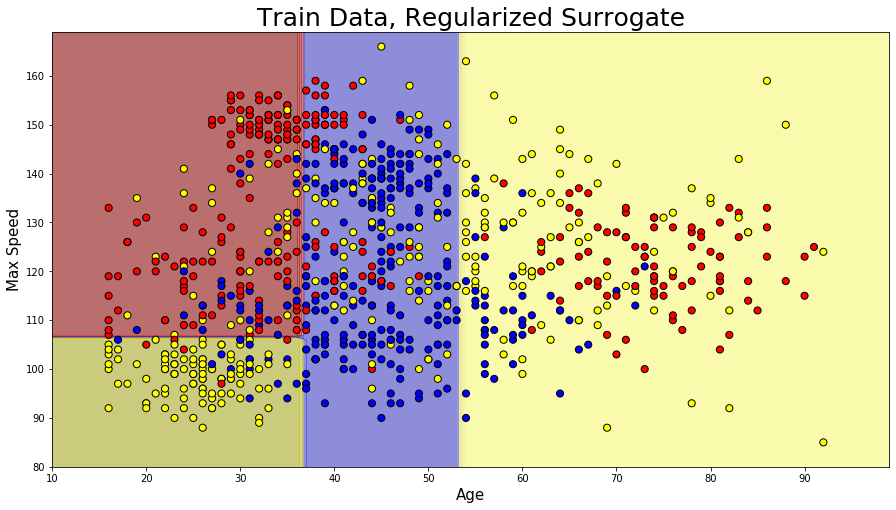

In [78]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 1

In [79]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=1)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 3.81 ms, sys: 0 ns, total: 3.81 ms
Wall time: 4.22 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [80]:
surrogate_model.tree_.max_depth

1

In [81]:
surrogate_model.score(mesh_data, pred_sparse)

0.5301234567901234

In [82]:
surrogate_model.score(X_train_2_dim, y_train)

0.35

In [83]:
surrogate_model.score(X_test_2_dim, y_test)

0.3516666666666667

In [84]:
surrogate_model.score(X_2_dim, y)

0.3506666666666667

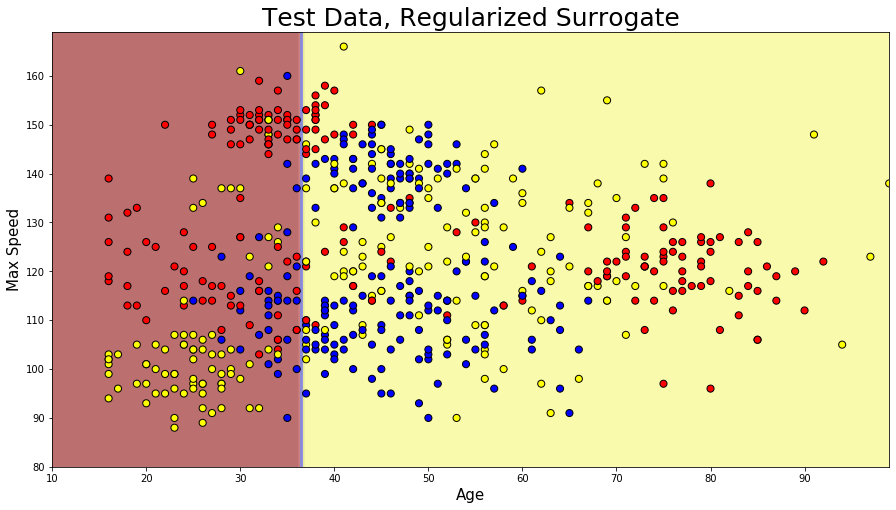

In [85]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

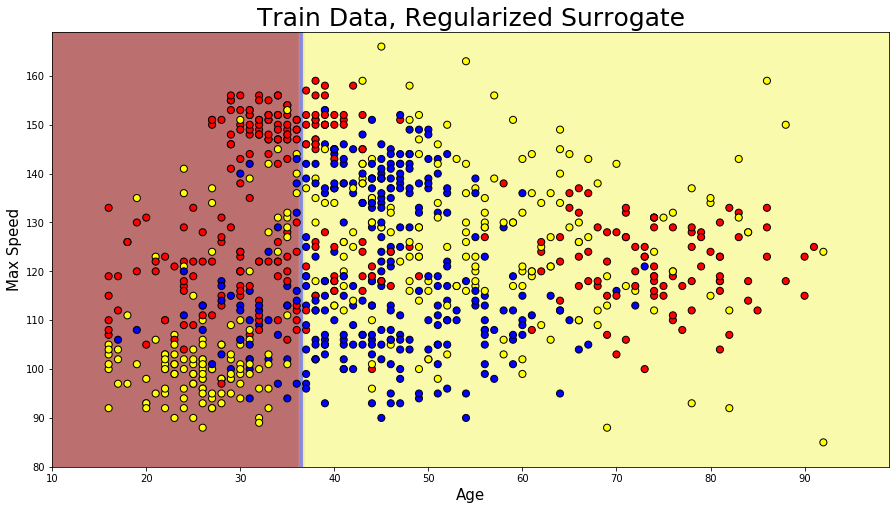

In [86]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Analyze for simple, but reasonable tree

In [87]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=4,
    presort=True,
    # max_leaf_nodes = 4
    max_leaf_nodes = 6
                                         )
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 4.9 ms, sys: 95 µs, total: 5 ms
Wall time: 6.1 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=None, splitter='best')

In [88]:
surrogate_model.tree_.max_depth

4

In [89]:
surrogate_model.score(mesh_data, pred_sparse)

0.8451851851851852

In [90]:
surrogate_model.score(X_train_2_dim, y_train)

0.6333333333333333

In [91]:
surrogate_model.score(X_test_2_dim, y_test)

0.6216666666666667

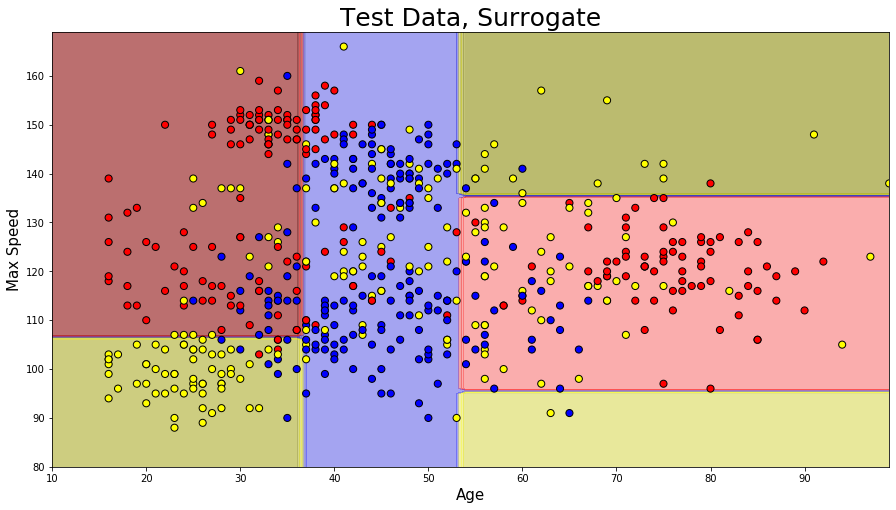

In [92]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

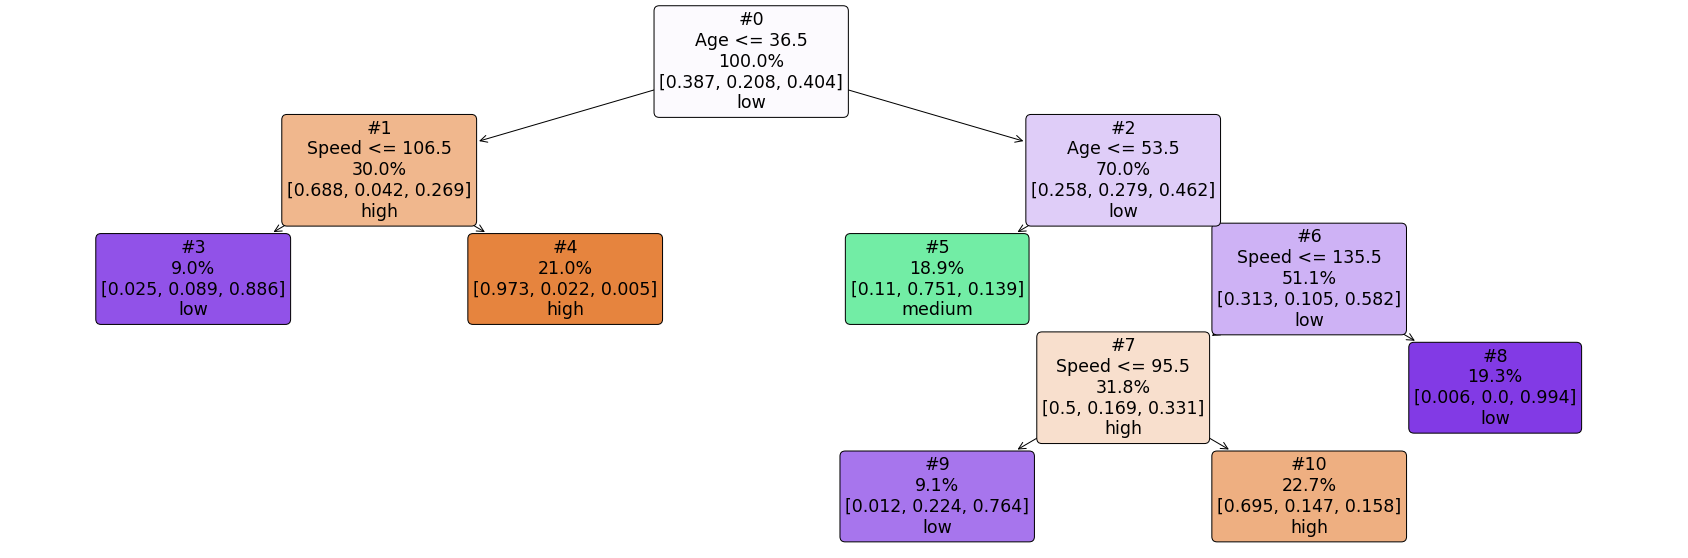

In [93]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['Speed', 'Age']
class_names=['high', 'medium', 'low']

plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

In [0]:
sample = [100, 35]
# sample = [100, 60]
# sample = [120, 17]

In [95]:
surrogate_model.predict([sample])

array([2])

In [96]:
leaf_id = surrogate_model.apply([sample])
leaf_id

array([3])

In [97]:
node_indicator = surrogate_model.decision_path([sample])
node_index = node_indicator.indices[node_indicator.indptr[0]:
                                    node_indicator.indptr[1]]
node_index

array([0, 1, 3], dtype=int32)

## Analyzing tree structure

In [98]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

from sklearn.tree import _tree

def explain_decision(model, sample, feature_names, class_names):

  feature = model.tree_.feature
  threshold = model.tree_.threshold
  value = model.tree_.value

  node_indicator = model.decision_path([sample])
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]

  for node_id in node_index:
      if feature[node_id] == _tree.TREE_UNDEFINED:
          print(class_names[value[node_id].argmax(axis=1)[0]])
          continue

      if (sample[feature[node_id]] <= threshold[node_id]):
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print("%s(= %s) %s %s"
            % (feature_names[feature[node_id]],
              sample[feature[node_id]],
              threshold_sign,
              threshold[node_id]))
      
explain_decision(surrogate_model, sample, feature_names, class_names)      

Age(= 35) <= 36.5
Speed(= 100) <= 106.5
low


In [99]:
# https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree

def generate_code(model, feature_names, class_names):
    tree_ = model.tree_
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print ("{}return '{}'".format(indent, class_names[value[node].argmax(axis=1)[0]]))

    recurse(0, 1)
generate_code(surrogate_model, feature_names, class_names)    

def tree(Speed, Age):
  if Age <= 36.5:
    if Speed <= 106.5:
      return 'low'
    else:  # if Speed > 106.5
      return 'high'
  else:  # if Age > 36.5
    if Age <= 53.5:
      return 'medium'
    else:  # if Age > 53.5
      if Speed <= 135.5:
        if Speed <= 95.5:
          return 'low'
        else:  # if Speed > 95.5
          return 'high'
      else:  # if Speed > 135.5
        return 'low'


## Even KNN is an option now, since we are no longer working on real data

In [100]:
from sklearn.neighbors import KNeighborsClassifier
surrogate_model = KNeighborsClassifier(n_neighbors=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 4.27 ms, sys: 1.95 ms, total: 6.22 ms
Wall time: 9.87 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [101]:
surrogate_model.score(mesh_data, pred_sparse)

0.9991358024691358

In [102]:
surrogate_model.score(X_train_2_dim, y_train)

0.7244444444444444

In [103]:
surrogate_model.score(X_test_2_dim, y_test)

0.7183333333333334

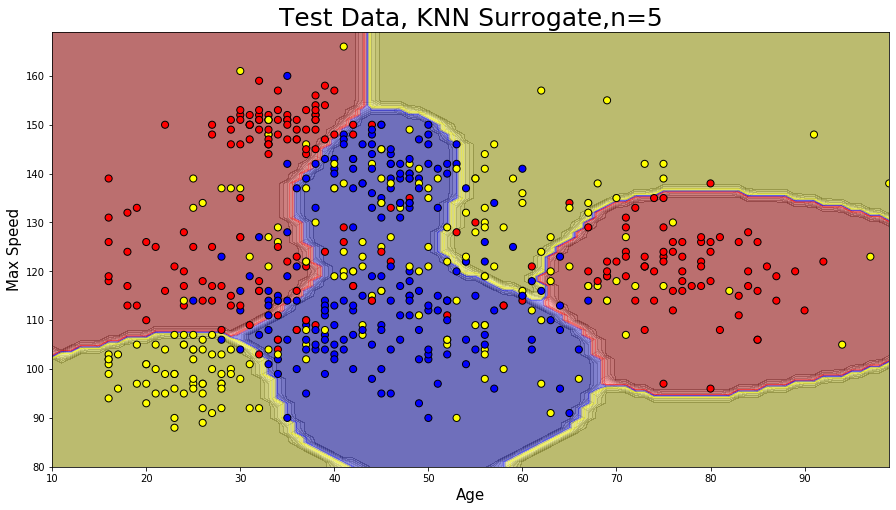

In [104]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN Surrogate,n=5");

In [105]:
from sklearn.neighbors import KNeighborsClassifier
surrogate_model = KNeighborsClassifier(n_neighbors=1)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.34 ms, sys: 0 ns, total: 6.34 ms
Wall time: 6.83 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [106]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [107]:
surrogate_model.score(X_train_2_dim, y_train)

0.7244444444444444

In [108]:
surrogate_model.score(X_test_2_dim, y_test)

0.7183333333333334

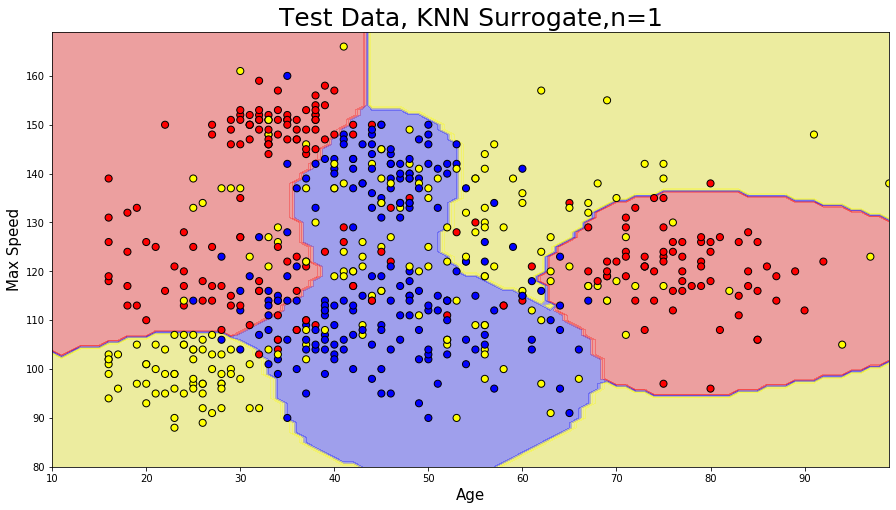

In [109]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, KNN Surrogate,n=1");